In [15]:
import logging
import warnings
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from arviz import summary

from analysis.bayescorr import runBayesCorr
from analysis.utilities import makeDirIfNeeded
from plotting.plot_share import break_after_nth_tick, lm, violin
from plotting.plot_utils import *

In [16]:
#% Preparations and settings
warnings.filterwarnings("ignore")

logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

# Random seed
SEED = 2077
np.random.seed(SEED)

# Plot settings
palette = [
    "slategray",
    "darksalmon",
    "mediumaquamarine",
    "indianred",
    "paleturquoise",
    "lightpink",
    "tan",
    "orchid",
]
matplotlib = set_mpl_defaults(matplotlib)

# MCMC settings (passed on to pm.sample)
sample_kwargs = {"cores": 1, "random_seed": SEED, "progressbar": False}

# Directories
RESULTS_DIR = join("..", "results")
OUTPUT_DIR = join("..", "results", "S_supplemental-analyses_model-predictions")
makeDirIfNeeded(OUTPUT_DIR)

# Which models to include, and how to name them in the plots
models = ["glickman1layer", "mdft", "gaze-baseline-dyn", "gaze-baseline-stat", "eu"]
model_labels = {
    "glickman1layer": "GLA",
    "mdft": "MDFT",
    "eu": "EU",
    "gaze-baseline-stat": "GB" + r"$_{stat}$",
    "gaze-baseline-dyn": "GB" + r"$_{dyn}$",
}

n_params = {
    "glickman1layer": 5,
    "mdft": 5,
    "eu": 2,
    "gaze-baseline-stat": 1,
    "gaze-baseline-dyn": 2,
}

In [17]:
#% Load data
# Load estimates and BICs
estimates = pd.read_csv(
    join(RESULTS_DIR, "3-behavioural-modeling", "estimates", "estimates_de1.csv")
)

# Load observed behaviour
trials = pd.read_csv(join(RESULTS_DIR, "0-clean_data", "trials_with-dwells.csv"))

# Load prediction dataframe (includes predictions of all models)
predictions = pd.read_csv(
    join(RESULTS_DIR, "3-behavioural-modeling", "predictions", "predictions_de1.csv")
)
## Add `choice_tcd` variable to predicted data
predictions["choice_tcd"] = np.where(
    pd.isnull(predictions["target"]),
    np.nan,
    np.where(
        predictions["predicted_choice"] == 2,
        "decoy",
        np.where(
            ((predictions["predicted_choice"] == 0) & (predictions["target"] == "A"))
            | ((predictions["predicted_choice"] == 1) & (predictions["target"] == "B")),
            "target",
            "competitor",
        ),
    ),
)

In [18]:
def lmr_plot(
    x,
    y,
    ax=None,
    lm_kwargs={},
    sample_kwargs={"cores": 1},
    annotation_pos="lower right",
):
    """Make a scatterplot with Bayesian linear regression and Bayesian correlation annotations."""

    if ax is None:
        ax = plt.gca()

    # Linear Model
    ax, lm_trace, lm_summary = lm(
        x=x, y=y, ax=ax, **lm_kwargs, sample_kwargs=sample_kwargs,
    )

    # Correlation
    corr_trace = runBayesCorr(y1=x, y2=y, sample_kwargs=sample_kwargs)
    corr_summary = summary(corr_trace, hdi_prob=0.95)

    # Annotation
    stat_str = (
        f"r = {corr_summary.loc['r', 'mean']:.2f} [{corr_summary.loc['r', 'hdi_2.5%']:.2f}, {corr_summary.loc['r', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Intercept = {lm_summary.loc['Intercept', 'mean']:.2f} [{lm_summary.loc['Intercept', 'hdi_2.5%']:.2f}, {lm_summary.loc['Intercept', 'hdi_97.5%']:.2f}]"
        + "\n"
        + f"Slope = {lm_summary.loc['x', 'mean']:.2f} [{lm_summary.loc['x', 'hdi_2.5%']:.2f}, {lm_summary.loc['x', 'hdi_97.5%']:.2f}]"
    )

    if "right" in annotation_pos:
        x = 1
        ma = "right"
        ha = "right"
    elif "left" in annotation_pos:
        x = 0.05
        ma = "left"
        ha = "left"

    if "lower" in annotation_pos:
        y = 0.05
        va = "bottom"
    elif "upper" in annotation_pos:
        y = 1
        va = "top"

    ax.annotate(
        stat_str, [x, y], ma=ma, ha=ha, va=va, fontsize=4, xycoords="axes fraction",
    )

    # Despine
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)

    return ax

In [19]:
def calc_rst(df, effect="attraction"):
    """Calculate RST.
    
    Parameters
    ----------
    df : pandas.DataFrame
        trial DataFrame, containing columns `subject`, `effect`, `choice_tcd`
    effect : str, one of ['attraction', 'compromise'], optional
        which effect to look at, by default 'attraction'
    
    Returns
    -------
    pandas.Series
        subject-wise RSTs
    """
    cs = (
        df.loc[df["effect"] == effect]
        .groupby("subject")["choice_tcd"]
        .value_counts()
        .rename("frequency")
        .reset_index()
        .pivot_table(index="subject", values="frequency", columns="choice_tcd")
        .fillna(0)
    )
    cs["rst"] = cs["target"] / (cs["target"] + cs["competitor"])
    return cs["rst"]

In [20]:
lm_kwargs = dict(xrange=(0, 1), line_color="lightgray")

# Observed RST vs predicted RST

GLA
  Attraction
  Compromise
MDFT
  Attraction
  Compromise
GB$_{dyn}$
  Attraction
  Compromise
GB$_{stat}$
  Attraction
  Compromise
EU
  Attraction
  Compromise


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


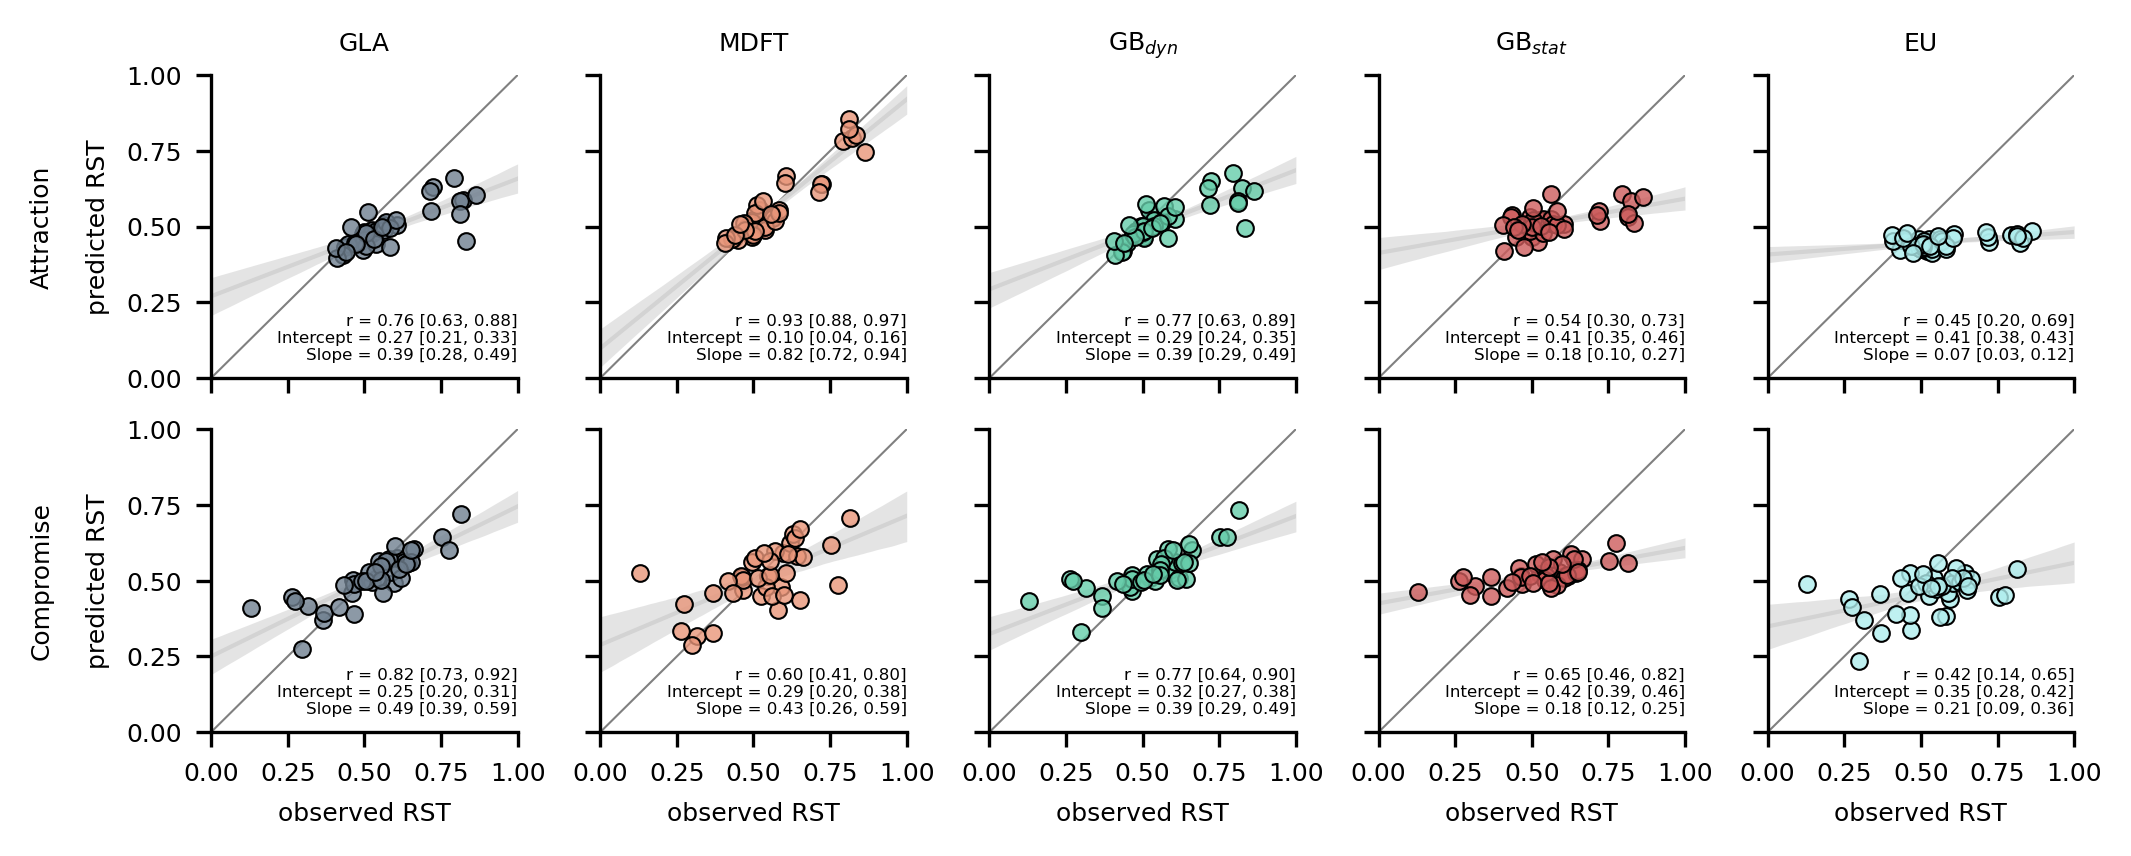

In [12]:
fig, axs = plt.subplots(
    2,
    len(models),
    figsize=cm2inch(18, 2 * 18 / len(models)),
    sharey="row",
    sharex="col",
)

for m, model in enumerate(models):
    model_label = model_labels[model]
    print(f"{model_label}")
    color = palette[m]
    lm_kwargs.update(scatter_color=color)

    for e, effect in enumerate(["attraction", "compromise"]):
        print(f"  {effect.capitalize()}")
        ax = axs[e, m]

        # Calculate observed RDT and model predicted RST
        rst_obs = calc_rst(trials, effect=effect)
        rst_pred = calc_rst(
            predictions.loc[predictions["model"] == model], effect=effect
        )

        # Run linear model
        ax = lmr_plot(
            rst_obs, rst_pred, ax=ax, lm_kwargs=lm_kwargs, sample_kwargs=sample_kwargs
        )

        # Annotations
        ## Diagonal for perfect prediction
        ax.plot([0, 1], [0, 1], linewidth=0.5, color="gray", zorder=-1)

        # Y-axis
        ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_ylim(0, 1)

        # X axis
        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(0, 1)

        # Labels
        if e == 1:
            ax.set_xlabel("observed RST")
        if e == 0:
            ax.set_title(f"{model_label}")
        if m == 0:
            ax.set_ylabel(f"{effect.capitalize()}\n\npredicted RST")

# Save figure
plt.tight_layout()
plt.savefig(join(OUTPUT_DIR, f"rst_rst-pred.pdf"), bbox_inches="tight")

# Observed RST vs observed relative dwell time toward the target (RDT)

$$RDT = \frac{DT_T}{DT_T + DT_C}$$

This is calculated per trial, and averaged across trials.

In [21]:
def calc_rdt(df, effect="attraction"):
    """Calculate RDT
    Relative dwell time to target = dwell time to target / (dwell time to target + dwell time to competitor)
    
    Parameters
    ----------
    df : pandas.DataFrame
        trial DataFrame, containing columns `subject`, `effect`, `dwell_target`, `dwell_competitor`
    effect : str, one of ['attraction', 'compromise'], optional
        which effect to look at, by default 'attraction'
    
    Returns
    -------
    pandas.Series
        subject-wise RSTs
    """
    # Add trial-wise RDT
    df["rdt"] = df["dwell_target"] / (df["dwell_target"] + df["dwell_competitor"])

    # Compute subject means
    rdt = df.loc[df["effect"] == effect].groupby("subject")["rdt"].mean()
    return rdt

Attraction
count    40.000000
mean      0.513512
std       0.024679
min       0.467624
25%       0.501192
50%       0.512402
75%       0.522160
max       0.591617
Name: rdt, dtype: float64


There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Compromise
count    40.000000
mean      0.518960
std       0.017114
min       0.487002
25%       0.506385
50%       0.516004
75%       0.530623
max       0.569921
Name: rdt, dtype: float64


There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


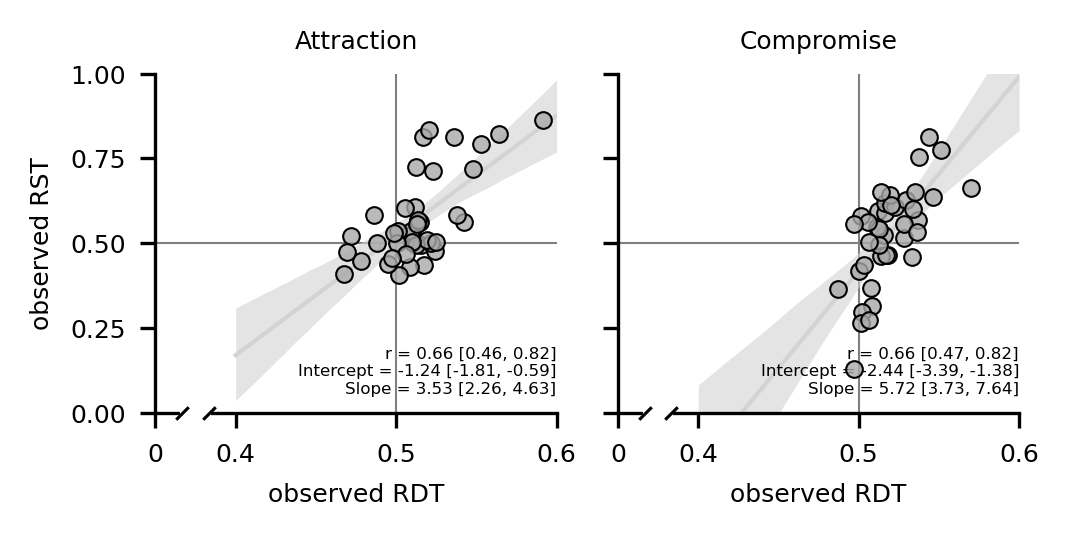

In [9]:
color = "darkgray"
lm_kwargs.update(scatter_color=color, xrange=(0.4, 0.6))

fig, axs = plt.subplots(1, 2, figsize=cm2inch(9, 4.5), sharey="row")

for e, effect in enumerate(["attraction", "compromise"]):
    print(f"{effect.capitalize()}")
    ax = axs[e]

    # Calculate observed measures
    rdt_obs = calc_rdt(trials, effect=effect)  # Relative dwell time to target
    rst_obs = calc_rst(trials, effect=effect)  # Relative choice share of target
    print(rdt_obs.describe())
    # Run linear model
    ax = lmr_plot(
        rdt_obs, rst_obs, ax=ax, lm_kwargs=lm_kwargs, sample_kwargs=sample_kwargs,
    )

    # Annotations
    ## Lines for equal choice and dwell time
    ax.axvline(0.5, color="gray", linewidth=0.5, zorder=-1)
    ax.axhline(0.5, color="gray", linewidth=0.5, zorder=-1)

    ## Y-axis
    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.set_ylim(0, 1)

    ## X axis
    ax.set_xticks([0.35, 0.4, 0.5, 0.6])
    ax.set_xlim(0.35, 0.6)
    ax.set_xticklabels([0, 0.4, 0.5, 0.6])
    break_after_nth_tick(ax, 0, axis="x")

    ## Labels
    ax.set_xlabel("observed RDT")
    if e == 0:
        ax.set_ylabel(f"observed RST")
    ax.set_title(f"{effect.capitalize()}")

# Save figure
plt.tight_layout()
plt.savefig(join(OUTPUT_DIR, f"rdt_rst-obs.pdf"), bbox_inches="tight")

# Observed RDT vs predicted RST

GLA
  Attraction


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


  Compromise


There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


MDFT
  Attraction


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


  Compromise


There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


GB$_{dyn}$
  Attraction


There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


  Compromise


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


GB$_{stat}$
  Attraction


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


  Compromise


There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


EU
  Attraction


There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


  Compromise


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


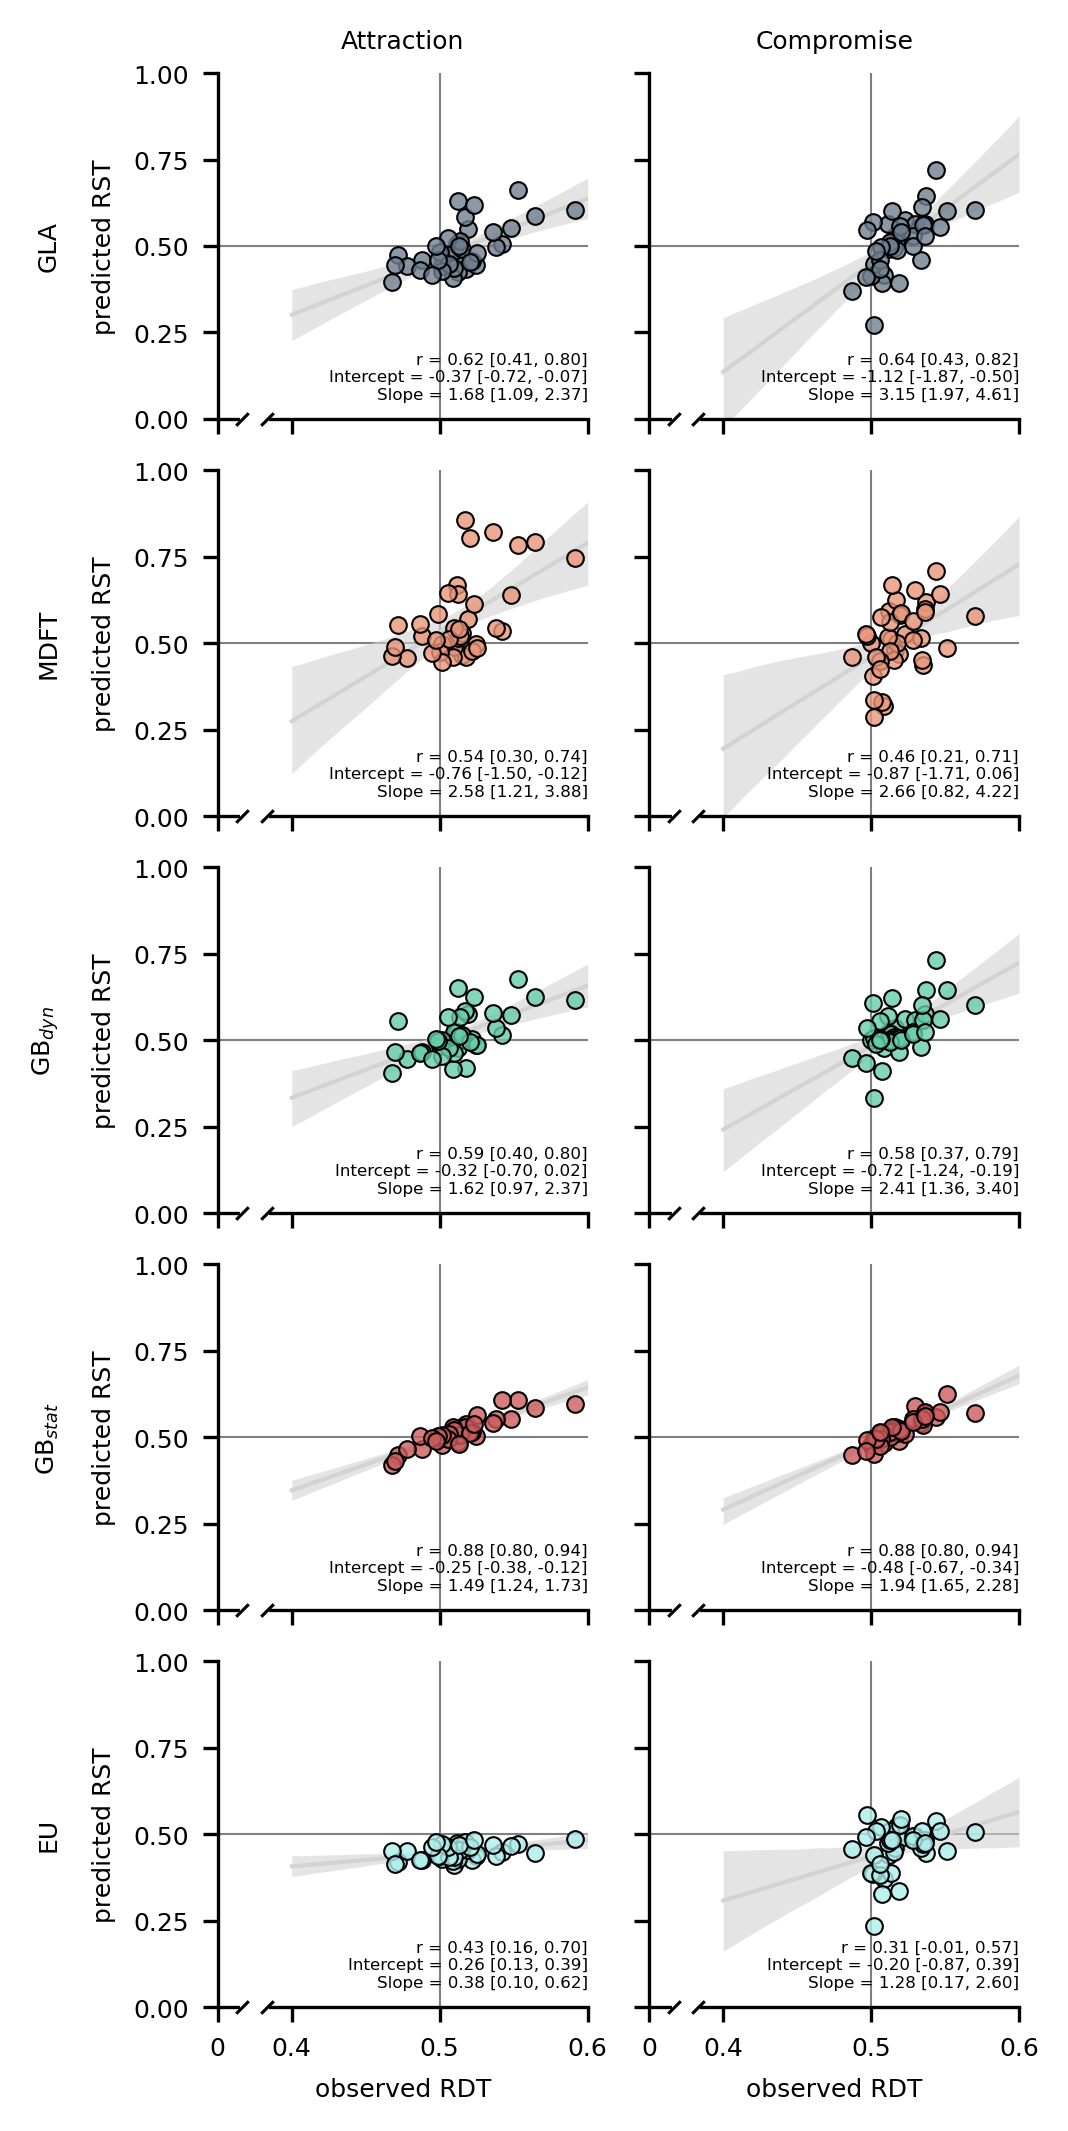

In [10]:
fig, axs = plt.subplots(
    len(models),
    2,
    figsize=cm2inch(9, len(models) * 4 / 5 * 4.5),
    sharey="row",
    sharex="col",
)

for m, model in enumerate(models):
    model_label = model_labels[model]
    print(f"{model_label}")
    color = palette[m]
    lm_kwargs.update(scatter_color=color, xrange=(0.4, 0.6))

    for e, effect in enumerate(["attraction", "compromise"]):
        print(f"  {effect.capitalize()}")
        ax = axs[m, e]

        # Calculate observed RDT and model predicted RST
        rdt_obs = calc_rdt(trials, effect=effect)
        rst_pred = calc_rst(
            predictions.loc[predictions["model"] == model], effect=effect
        )

        # Run linear model
        ax = lmr_plot(
            rdt_obs, rst_pred, ax=ax, lm_kwargs=lm_kwargs, sample_kwargs=sample_kwargs,
        )

        # Annotations
        ## Lines for equal choice and dwell time
        ax.axvline(0.5, color="gray", linewidth=0.5, zorder=-1)
        ax.axhline(0.5, color="gray", linewidth=0.5, zorder=-1)

        # Y-axis
        ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_ylim(0, 1)

        # X axis
        ax.set_xticks([0.35, 0.4, 0.5, 0.6])
        ax.set_xlim(0.35, 0.6)
        ax.set_xticklabels([0, 0.4, 0.5, 0.6])
        break_after_nth_tick(ax, 0, axis="x")

        # Labels
        if m == (len(models) - 1):
            ax.set_xlabel("observed RDT")
        if e == 0:
            ax.set_ylabel(f"{model_label}\n\npredicted RST")
        if m == 0:
            ax.set_title(f"{effect.capitalize()}")

# Save figure
plt.tight_layout()
plt.savefig(join(OUTPUT_DIR, f"rdt_rst-pred.pdf"), bbox_inches="tight")

# Compute BIC separately for attraction and compromise trials

In [22]:
# get smaller prediction dataframe
df = (
    predictions.loc[
        (predictions["rep"] == 0),
        [
            "model",
            "subject",
            "trial",
            "effect",
            "target",
            "choice",
            "predicted_choice",
            "predicted_choiceprob_A",
            "predicted_choiceprob_B",
            "predicted_choiceprob_C",
        ],
    ]
    .reset_index(drop=True)
    .rename(
        {
            "predicted_choiceprob_A": "pcp_0",
            "predicted_choiceprob_B": "pcp_1",
            "predicted_choiceprob_C": "pcp_2",
        },
        axis=1,
    )
)

# Add: Model predicted probability of choosing target option
df["pcp_target"] = np.where(
    pd.isnull(df["target"]),
    np.nan,
    np.where(df["target"] == "A", df["pcp_0"], df["pcp_1"]),
)

# Add: Model predicted probability of choosing competitor option
df["pcp_competitor"] = np.where(
    pd.isnull(df["target"]),
    np.nan,
    np.where(df["target"] == "A", df["pcp_1"], df["pcp_0"]),
)

# Add: Model predicted probability of choosing decoy option (that's a little easier. Decoy is always third option)
df["pcp_decoy"] = df["pcp_2"]

# Add: Model predicted probability of choice of empirically chosen option
df["pcp_chosen"] = np.where(
    df["choice"] == 0,
    df["pcp_0"],
    np.where(df["choice"] == 1, df["pcp_1"], df["pcp_2"]),
)
df["log_pcp_chosen"] = np.log(df["pcp_chosen"])

df.head()

,model,subject,trial,effect,target,choice,predicted_choice,pcp_0,pcp_1,pcp_2,pcp_target,pcp_competitor,pcp_decoy,pcp_chosen,log_pcp_chosen
0,eu,0,1,attraction,A,0,1,0.354121,0.396845,0.249033,0.354121,0.396845,0.249033,0.354121,-1.038115
1,eu,0,2,attraction,B,1,2,0.303064,0.404291,0.292645,0.404291,0.303064,0.292645,0.404291,-0.905620
2,eu,0,3,attraction,A,2,0,0.349371,0.400640,0.249989,0.349371,0.400640,0.249989,0.249989,-1.386339
3,eu,0,4,attraction,B,2,0,0.340152,0.381191,0.278657,0.381191,0.340152,0.278657,0.278657,-1.277775
4,eu,0,5,filler,NaN,2,0,0.280635,0.322519,0.396846,NaN,NaN,0.396846,0.396846,-0.924207


In [23]:
# Compute summed log likelihoods and BICs for each subject, model and effect
subject_lls_effect = (
    df.loc[df["effect"].isin(["attraction", "compromise"])]
    .groupby(["model", "effect", "subject"])["log_pcp_chosen"]
    .sum()
    .reset_index()
    .rename({"log_pcp_chosen": "ll"}, axis=1)
)

# Compute BICs (96 trials of each effect type)
subject_lls_effect["bic"] = -2 * subject_lls_effect["ll"] + np.log(96) * np.array(
    [n_params[model] for model in subject_lls_effect["model"]]
)

subject_lls_effect.head()

,model,effect,subject,ll,bic
0,eu,attraction,0,-99.243389,207.615474
1,eu,attraction,1,-80.187741,169.504179
2,eu,attraction,2,-35.062756,79.254209
3,eu,attraction,3,-75.356047,159.840790
4,eu,attraction,4,-92.074773,193.278242


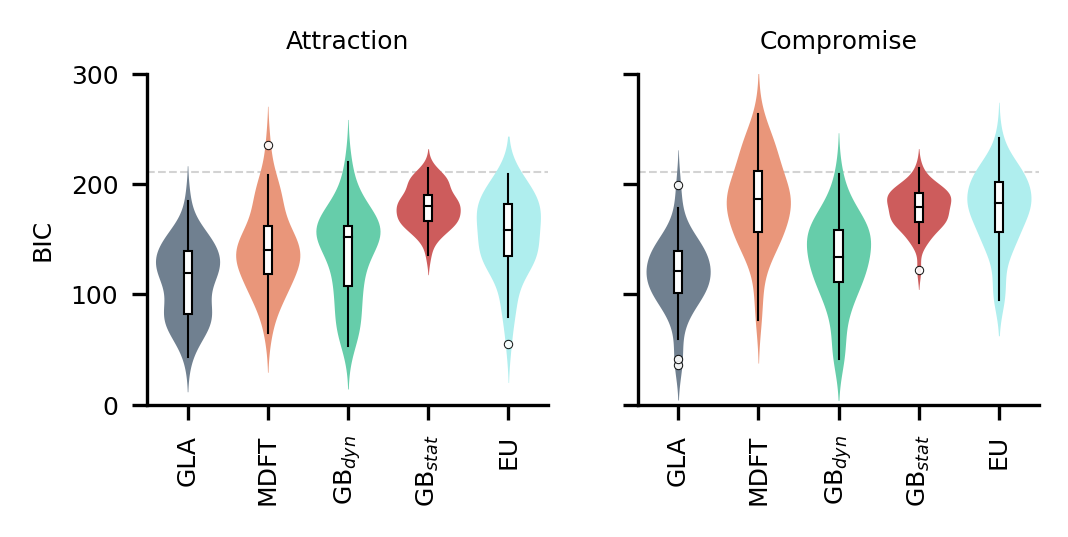

In [9]:
# Make a violinplot
# Reformat data for plot (wide format, each column is one violin)
bics = subject_lls_effect.pivot_table(
    values="bic", index=["effect", "subject"], columns="model"
)
bics.columns.name = "variable"  # this is needed for the violinplot function, something to fix in the future

fig, axs = plt.subplots(1, 2, figsize=cm2inch(9, 4.5), sharey="row")

for e, effect in enumerate(["attraction", "compromise"]):
    # Make a violin plot of log likelihoods for each model
    ax = violin(bics.loc[effect, models], palette=palette, ax=axs[e])

    # Add dashed line for random performance
    ax.axhline(
        -2 * 96 * np.log(1 / 3),
        color="lightgray",
        linestyle="--",
        linewidth=0.5,
        zorder=-1,
    )

    # Adjust labels and titles
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels([model_labels[model] for model in models], rotation=90)
    ax.set_xlabel(None)
    if e == 0:
        ax.set_ylabel("BIC")
    else:
        ax.set_ylabel(None)
    ax.set_ylim(0, 300)
    ax.set_yticks(np.arange(0, 301, 100))
    ax.set_title(f"{effect.capitalize()}")

plt.tight_layout(w_pad=3)
plt.savefig(join(OUTPUT_DIR, f"bics_by-effect.pdf"), bbox_inches="tight")

In [10]:
bics.groupby("effect").agg(["mean", "sem"]).T

effect                   attraction  compromise
eu                 mean  153.217116  176.486195
                   sem     5.732224    5.396697
gaze-baseline-dyn  mean  137.790572  132.000748
                   sem     6.403682    6.142261
gaze-baseline-stat mean  179.520360  177.457951
                   sem     2.897113    2.911535
glickman1layer     mean  112.552757  118.374373
                   sem     5.240922    5.195307
mdft               mean  142.061021  182.937598
                   sem     5.839788    6.401794

# Model-predicted probabilities of chosen alternative, target alternative, ...

In [24]:
pcps = (
    df.loc[df["effect"].isin(["attraction", "compromise"])]
    .groupby(["effect", "model", "subject"])[
        ["pcp_target", "pcp_competitor", "pcp_decoy", "pcp_chosen"]
    ]
    .mean()
)
pcps.head()

pcp_target  pcp_competitor  pcp_decoy  pcp_chosen
effect     model subject                                                   
attraction eu    0          0.352961        0.392294   0.254746    0.372286
                 1          0.357068        0.449019   0.193913    0.509976
                 2          0.379489        0.518787   0.101723    0.722960
                 3          0.358785        0.424935   0.216280    0.483435
                 4          0.353111        0.398427   0.248462    0.402961

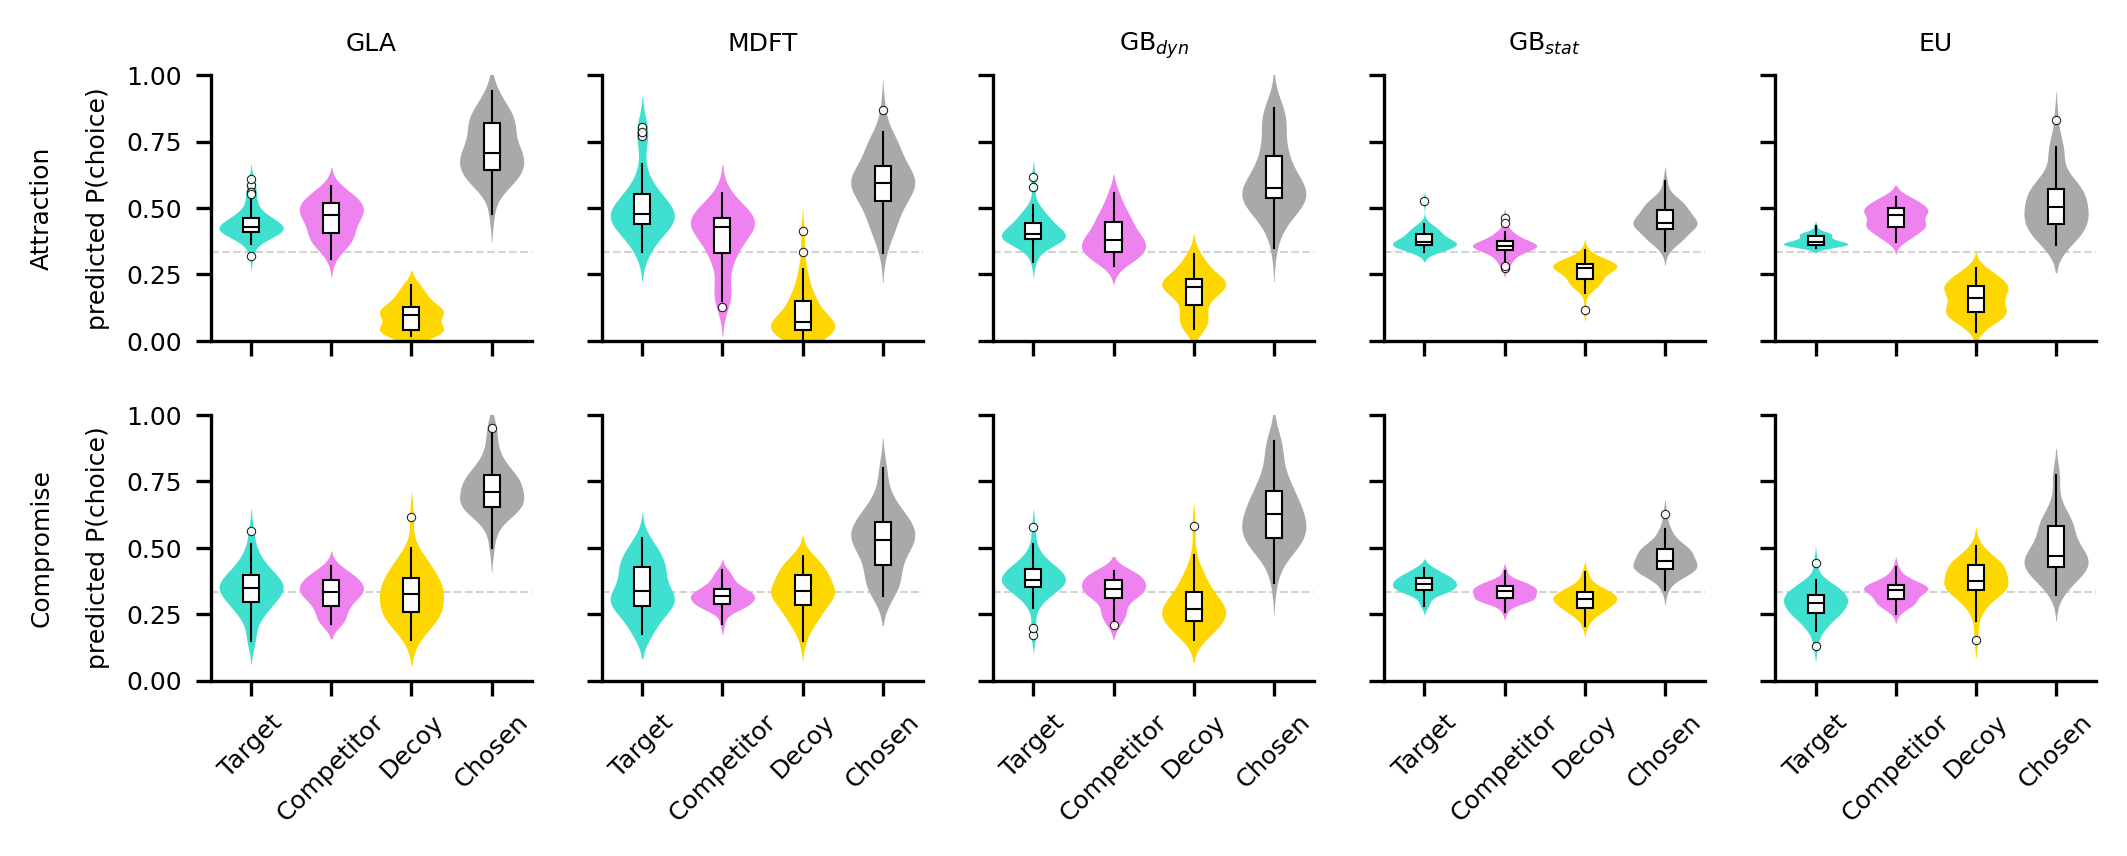

In [25]:
fig, axs = plt.subplots(
    2,
    len(models),
    figsize=cm2inch(18, 18 * 2 / len(models)),
    sharex="col",
    sharey="row",
)

for m, model in enumerate(models):
    for e, effect in enumerate(["attraction", "compromise"]):

        # Make a violin plot of log likelihoods for each model
        ax = violin(
            pcps.loc[effect, model],
            palette=["turquoise", "violet", "gold"] + ["darkgray"],
            ax=axs[e, m],
            box_width=0.2,
        )

        # Add dashed line for random performance
        ax.axhline(
            (1 / 3), color="lightgray", linestyle="--", linewidth=0.5, zorder=-1,
        )

        # Adjust labels and titles
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(["Target", "Competitor", "Decoy", "Chosen"], rotation=45)
        ax.set_xlabel(None)

        if m == 0:
            ax.set_ylabel(f"{effect.capitalize()}\n\npredicted P(choice)")
        else:
            ax.set_ylabel(None)
        if e == 0:
            ax.set_title(f"{model_labels[model]}")

        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.01, 0.25))

plt.tight_layout(w_pad=2, h_pad=2)
plt.savefig(join(OUTPUT_DIR, f"pred-choiceprobs.pdf"), bbox_inches="tight")

# Focus on strong responders

In [13]:
rst_obs = calc_rst(trials, effect="attraction")
strong_responders = rst_obs.index[rst_obs > 0.7]
strong_responders

Int64Index([0, 5, 7, 14, 19, 22, 32, 35, 42], dtype='int64', name='subject')

In [14]:
cs = (
    trials.loc[
        (trials["subject"].isin(strong_responders)) & (trials["effect"] == "attraction")
    ]
    .groupby("subject")["choice_tcd"]
    .value_counts(normalize=True)
)

cs_summary = cs.groupby("choice_tcd").aggregate(["mean", "sem"])
cs_summary

,mean,sem
choice_tcd,,
competitor,0.209491,0.018079
decoy,0.023438,0.006554
target,0.780093,0.019829


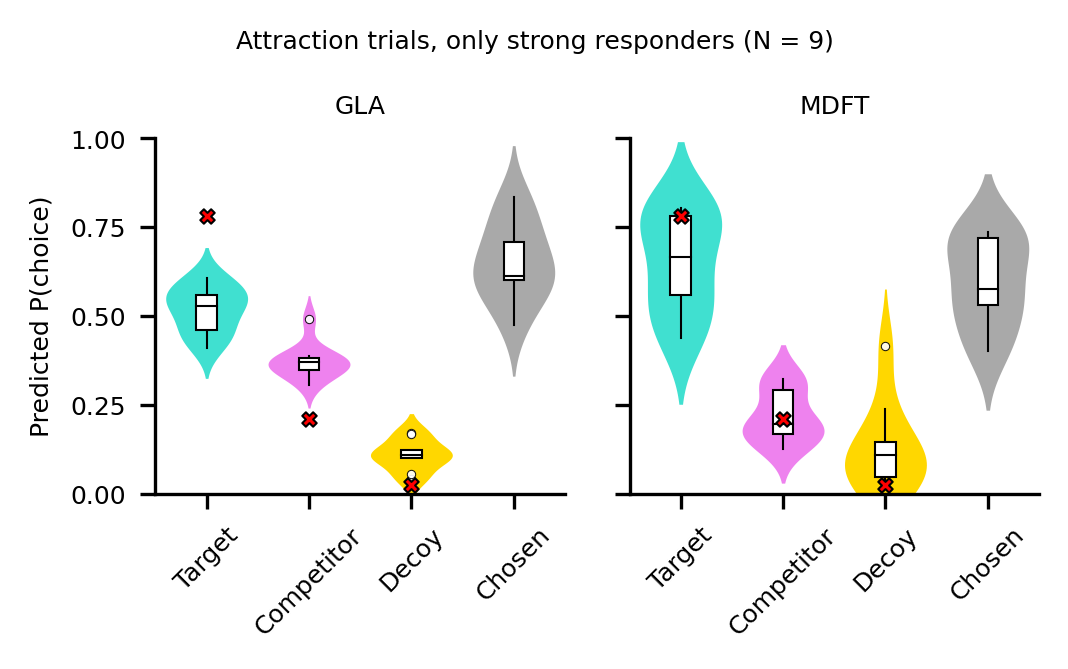

In [19]:
pcps_attr = pcps.loc["attraction"]

fig, axs = plt.subplots(1, 2, figsize=cm2inch(9, 5.5), sharex="col", sharey="row",)

for m, model in enumerate(["glickman1layer", "mdft"]):
    pcps_attr_m_sr = pcps_attr.loc[model].loc[strong_responders]

    # Make a violin plot of log likelihoods for each model
    ax = violin(
        pcps_attr_m_sr,
        palette=["turquoise", "violet", "gold"] + ["darkgray"],
        ax=axs[m],
        box_width=0.2,
    )

    # Add observed choice shares
    ax.scatter(
        [0, 1, 2],
        cs_summary.loc[["target", "competitor", "decoy"], "mean"],
        marker="X",
        color="red",
        edgecolor="black",
        s=12,
        linewidth=0.5,
        zorder=3,
    )

    # Adjust labels and titles
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(["Target", "Competitor", "Decoy", "Chosen"], rotation=45)
    ax.set_xlabel(None)
    if m == 0:
        ax.set_ylabel(f"Predicted P(choice)")
    else:
        ax.set_ylabel(None)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.01, 0.25))

    ax.set_title(f"{model_labels[model]}")

fig.suptitle("Attraction trials, only strong responders (N = 9)")
plt.tight_layout(w_pad=2, h_pad=2)
plt.savefig(
    join(OUTPUT_DIR, f"pred-choiceprobs_attr-strong-responders_gla_mdft.pdf"),
    bbox_inches="tight",
)

# Overall proportion of correctly predicted choices

In [20]:
predictions["correct_prediction"] = (
    predictions["choice"] == predictions["predicted_choice"]
)

predictions.groupby(["model", "subject"])["correct_prediction"].mean().groupby(
    "model"
).aggregate(["mean", "sem"])

,mean,sem
model,,
eu,0.537737,0.015876
gaze-baseline-dyn,0.628716,0.019796
gaze-baseline-stat,0.456558,0.008377
glickman1layer,0.742328,0.014169
mdft,0.578519,0.017523


In [21]:
correct_predictions = (
    predictions.groupby(["model", "subject"])["correct_prediction"]
    .mean()
    .reset_index()
    .pivot_table(index="subject", values="correct_prediction", columns="model")
)
correct_predictions.columns.name = "variable"

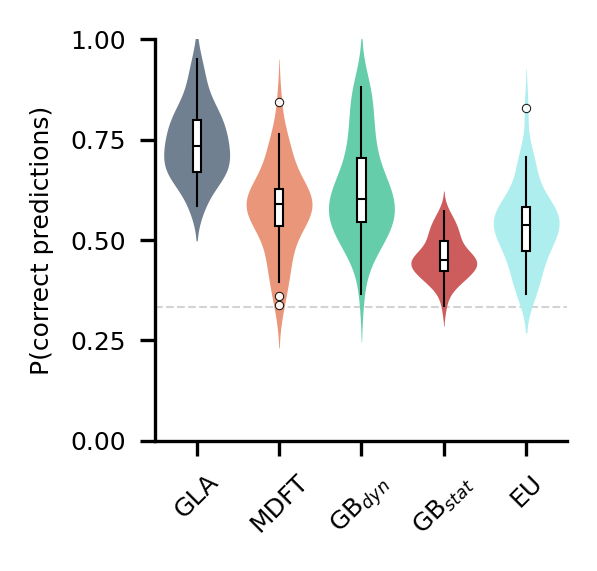

In [22]:
fig, ax = plt.subplots(figsize=cm2inch(4.5, 4.5))

ax = violin(correct_predictions[models], palette=palette, ax=ax)
ax.axhline(1 / 3, linewidth=0.5, color="lightgray", linestyle="--", zorder=-1)

# Ticks and labels
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels([model_labels[model] for model in models], rotation=45)
ax.set_xlabel(None)
ax.set_ylabel("P(correct predictions)")
ax.set_yticks(np.arange(0, 1.01, 0.25))
ax.set_ylim(0, 1)
plt.savefig(
    join(OUTPUT_DIR, f"p-pred-correct.pdf"), bbox_inches="tight",
)

## By effect

In [27]:
correct_predictions_effect = (
    predictions.groupby(["model", "effect", "subject"])["correct_prediction"]
    .mean()
    .groupby(["model", "effect"])
    .aggregate(["mean", "sem"])
)
correct_predictions_effect

mean       sem
model              effect                        
eu                 attraction  0.516736  0.017464
                   compromise  0.494474  0.016287
                   filler      0.724713  0.039788
gaze-baseline-dyn  attraction  0.616362  0.021086
                   compromise  0.632671  0.019907
                   filler      0.653172  0.021099
gaze-baseline-stat attraction  0.454185  0.009182
                   compromise  0.461071  0.009210
                   filler      0.450360  0.009349
glickman1layer     attraction  0.723903  0.016895
                   compromise  0.720418  0.015244
                   filler      0.859668  0.019489
mdft               attraction  0.591757  0.018461
                   compromise  0.525164  0.018432
                   filler      0.695300  0.039224